In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import erfc, erfcinv
from scipy.optimize import minimize, curve_fit
import sympy

from pathlib import Path
from IPython.display import Image, display
import ipywidgets as widgets  # interactive display

import pyNN.nest as sim
import nest
import quantities as pq

from importlib import reload

import cell_library
import simulations

data_path = Path('/home/pavel/academia/mean-field-CSNG/data/')



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Oct  8 2024 11:09:27

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Nov 14 14:44:26 Install [Info]: 
    loaded module PyNN extensions for NEST


nest available models:
- https://nest-simulator.readthedocs.io/en/stable/models/index.html

neuron model is from PyNN:
- PyNN model = 'EIF_cond_exp_isfa_ista'
    - EIF - Exponential Integrate-and-Fire
    - cond - conductance-based
    - exp - exponential synapses
    - isfa - spike-frequency adaptation ('b' part in adaptation)
    - ista - subthreshold adaptation ('a' part in adaptation)
    - http://neuralensemble.org/docs/PyNN/standardmodels.html
- nest model = 'aeif_cond_exp'
    - https://nest-simulator.readthedocs.io/en/stable/models/aeif_cond_exp.html
- NEST and PyNN have different units

tsodyks_synapse used:
- https://nest-simulator.readthedocs.io/en/stable/models/tsodyks_synapse.html

NEST examples with tsodyks_synapse:
- https://nest-simulator.readthedocs.io/en/stable/auto_examples/evaluate_tsodyks2_synapse.html
- https://nest-simulator.readthedocs.io/en/stable/auto_examples/iaf_tum_2000_short_term_depression.html


# Cellular measuments
$(\nu_e, \nu_i) \to \nu_{out}$

data from Faycal, saved in `./data/neuropsi-tf-cells`


In [2]:
cell_data_path = data_path /  'neuropsi-tf-cells'
TC = {
    'name': 'TC',
    'type': 'Thalamocortical cell',
    'nu_out': np.load(cell_data_path / 'ExpTF_exc_Nstp40_new.npy').T,  # 40x40 
    'nu_e': np.linspace(0, 40, 40), 
    'nu_i': np.linspace(0, 170, 40) 
}

RE = {
    'name': 'RE',
    'type': 'Thalamo-reticular cell',
    'nu_out': np.load(cell_data_path / 'ExpTF_inh_Nstp40_new.npy').T,  # 40x40
    'nu_e': np.linspace(0, 40, 40), 
    'nu_i': np.linspace(0, 170, 40) 
}


RS = {
    'name': 'RS',
    'type': 'Regular-spiking cell',
    'nu_out': np.load(cell_data_path / 'ExpTF_cortex_exc_Nstp21.npy').T,  # 21x21
    'nu_e': np.linspace(0, 150, 21),
    'nu_i': np.linspace(0, 150, 21),
}

FS = {
    'name': 'FS',
    'type': 'Fast-spiking cell',
    'nu_out': np.load(cell_data_path / 'ExpTF_cortex_inh_Nstp21.npy').T,  # 21x21
    'nu_e': np.linspace(0, 150, 21),
    'nu_i': np.linspace(0, 150, 21),
}

RS2 = {
    'name': 'RS2',
    'type': 'Regular-spiking cell',
    'nu_out': np.load(cell_data_path / 'ExpTF_cortex_exc_Nstp21_single.npy').T,  # 21x21
    'nu_e': np.linspace(0, 150, 21),
    'nu_i': np.linspace(0, 150, 21),
}

FS2 = {
    'name': 'FS2',
    'type': 'Fast-spiking cell',
    'nu_out': np.load(cell_data_path / 'ExpTF_cortex_inh_Nstp21_single.npy').T,  # 21x21
    'nu_e': np.linspace(0, 150, 21),
    'nu_i': np.linspace(0, 150, 21),
}

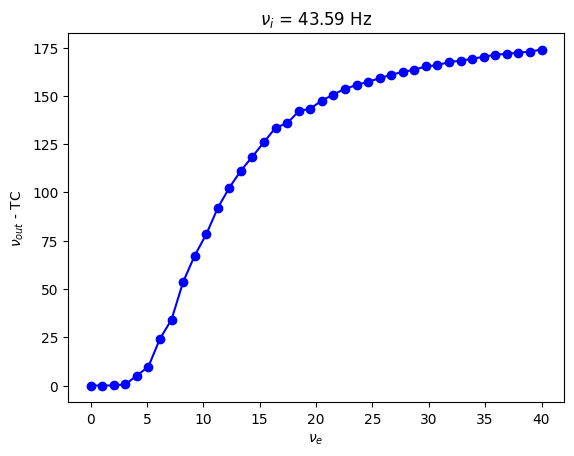

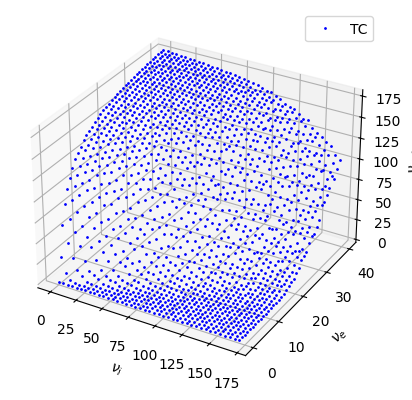

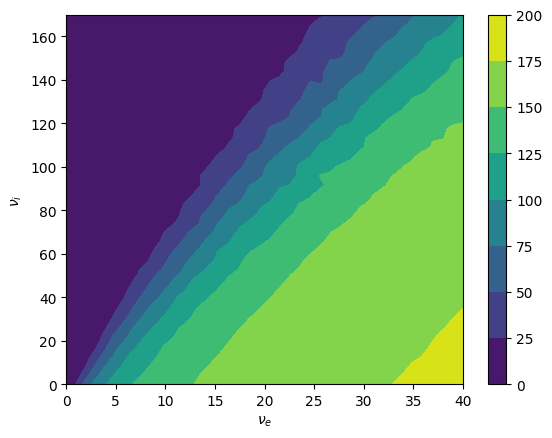

In [3]:
# This cell makes several plots of the data for chosen cell
cell = TC
i = 10 # choose inhibitory input


# Fig1:  the output of the cell for different excitatory inputs
plt.plot(cell['nu_e'], cell['nu_out'][i], '-ob')
plt.title(fr'$\nu_i$ = {cell["nu_i"][i]:.2f} Hz')
plt.xlabel(r'$\nu_e$')
plt.ylabel(rf'$\nu_{{out}}$ - {cell["name"]}')
plt.show()

# Fig2: 3D plot of the output of the cell for different inhibitory and excitatory inputs
ax = plt.axes(projection='3d')
nnu_e, nnu_i = np.meshgrid(cell['nu_e'], cell['nu_i'])
ax.plot3D(nnu_i.flatten(), nnu_e.flatten(), cell['nu_out'].flatten(), 'ob', markersize=1,label=cell['name'])
ax.set_xlabel(r'$\nu_i$')
ax.set_ylabel(r'$\nu_e$')
ax.set_zlabel(r'$\nu_{out}$')
ax.legend()
plt.show()

# Fig3: 2D plot of the output of the cell for different inhibitory and excitatory inputs
# plt.imshow(cell['nu_out'])
# plt.yticks(ticks=np.linspace(0, len(cell['nu_i']) - 1, 8, dtype=int), labels=[f'{cell["nu_i"][int(i)]:.1f}' for i in np.linspace(0, len(cell['nu_i']) - 1, 8)])
plt.contourf(cell['nu_e'], cell['nu_i'], cell['nu_out'])
plt.xlabel(r'$\nu_e$')
plt.ylabel(r'$\nu_i$')
plt.colorbar()
plt.show()

# Neuron models

Here are defined various models
- One based on CSNG V1 model
- One based on Zerlaut paper
- One based on di Volo paper

Expected input are parameters, then we do simulations to get data $(\nu_e, \nu_i,w) \to \nu_{out}$ for which we make fit of transfer function

In [13]:
reload(cell_library)
neurons = cell_library.load_all_neurons()

neuron_name = 'V1_Exc_L4'
# neuron_name = 'zerlaut_exc'
# neuron_name = 'zerlaut_inh'

# Picking the cell to simulate
sim_pars = neurons[neuron_name]
# NOTE: weight should be positive and receptor_type is where to specify exc/inh
sim_pars

{'neuron_params': {'v_rest': -80,
  'v_reset': -60.0,
  'tau_refrac': 2.0,
  'tau_m': 8.0,
  'cm': 0.032,
  'e_rev_E': 0.0,
  'e_rev_I': -80.0,
  'tau_syn_E': 1.5,
  'tau_syn_I': 4.2,
  'a': -0.8,
  'b': 0.08,
  'delta_T': 0.8,
  'tau_w': 1.0,
  'v_thresh': -57.0},
 'synapse_type': 'tsodyks_synapse',
 'simulation_time': 1000.0,
 'poisson_input': True,
 'exc_syn_params': {'weight': 0.18000000000000002,
  'delay': 1.0,
  'U': 0.75,
  'tau_rec': 30,
  'tau_psc': 3.0,
  'tau_fac': 0.0},
 'exc_syn_number': 640,
 'inh_syn_params': {'weight': 1.0,
  'delay': 1.0,
  'U': 0.75,
  'tau_rec': 70,
  'tau_psc': 3.0,
  'tau_fac': 0.0},
 'inh_syn_number': 200}

### Simulation of the cell

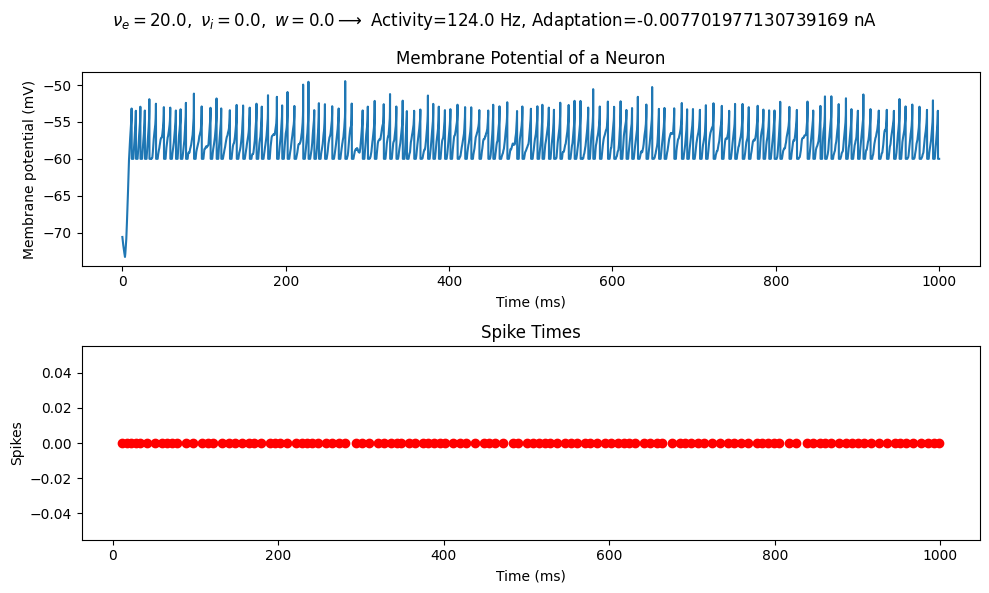

In [5]:
reload(simulations)

nu_e = 20.
nu_i = 0.
w = 0.

membrane_potential, spike_times, adaptation = simulations.simulate_neuron_pynn(nu_e, nu_i, **sim_pars)

activity = simulations.activity_from_spikes(spike_times, sim_pars['simulation_time']) 
adaptation = np.mean(adaptation[adaptation.size//2:])
plt.figure(figsize=(10, 6))
plt.suptitle(fr"$\nu_e={nu_e},~ \nu_i={nu_i},~ w={w} \longrightarrow$ Activity={activity} Hz, Adaptation={adaptation}")

# Plot membrane potential
plt.subplot(2, 1, 1)
plt.plot(membrane_potential.times, membrane_potential)
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.title("Membrane Potential of a Neuron")

# Plot spike times
plt.subplot(2, 1, 2)
plt.plot(spike_times, [0]*len(spike_times), 'ro')  # Plot spike times as red dots
plt.xlabel("Time (ms)")
plt.ylabel("Spikes")
plt.title("Spike Times")
plt.tight_layout()
plt.show()


### Simulation for a range of excitatory and inhibitory inputs

In [3]:
nu_e_range = np.linspace(0, 40, 40)
nu_i_range = np.linspace(0, 170, 40)

activity = np.zeros((nu_e_range.size, nu_i_range.size))
adaptations = np.zeros((nu_e_range.size, nu_i_range.size))

for i, nu_e in enumerate(nu_e_range):
    for j, nu_i in enumerate(nu_i_range):
        membrane_potential, spike_times, adaptation = simulations.simulate_neuron_pynn(nu_e, nu_i, **sim_pars)
        activity[i, j] = simulations.activity_from_spikes(spike_times, 1000.)
        adaptations[i, j] = np.mean(adaptation[adaptation.size//2:])
np.save(data_path / f'{neuron_name}-activity-{activity.shape[0]}x{activity.shape[1]}.npy', activity)
np.save(data_path / f'{neuron_name}-adaptation-{activity.shape[0]}x{activity.shape[1]}.npy', adaptations)


In [4]:
nu_e_range = np.linspace(0, 40, 40)
nu_i_range = np.linspace(0, 170, 40)
activity = np.load(data_path / f'{neuron_name}-activity.npy')
adaptations = np.load(data_path / f'{neuron_name}-adaptation.npy')

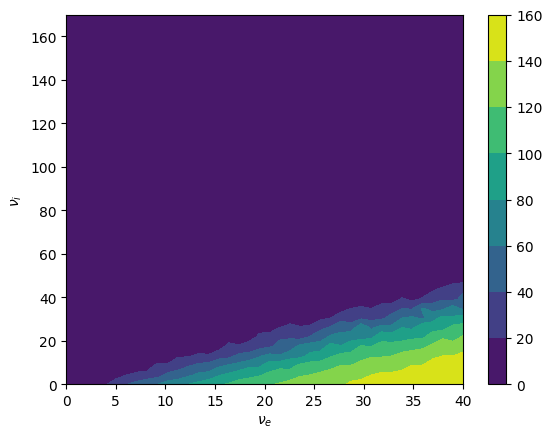

In [4]:
# plt.tricontourf(nu_e_range, nu_i_range, activity)
# plt.xlabel("Excitatory rate (Hz)")
# plt.ylabel("Inhibitory rate FS.shape(Hz)")
# plt.title("Activity of a neuron")
# plt.colorbar()
# plt.show()FS.shape

# this looks weird...
plt.contourf(nu_e_range, nu_i_range, activity.T)
plt.xlabel(r'$\nu_e$')
plt.ylabel(r'$\nu_i$')
plt.colorbar()

# Some plots
# First is a plot for a given inhibitory input
# Second is a 3D plot of the whole thing

# i = 10 # choose inhibitory input

# plt.plot(ve, RS[i], '-ob')
# plt.plot(ve, RS2[i], '-or')
# plt.title(f'vi = {vi[i]:.2f} Hz')
# plt.xlabel('ve')
# plt.ylabel('vout TC')

# ax = plt.axes(projection='3d')
# ax.plot3D(vvi.flatten(), vve.flatten(), RS.flatten(), 'ob', markersize=1,label='FE')
# ax.plot3D(vvi.flatten(), vve.flatten(), FS.flatten(), 'or', markersize=1,label='FI')

# ax.set_xlabel('vi')
# ax.set_ylabel('ve')
# ax.set_zlabel('vout')
# ax.legend();

### Fiting Transfer function

$ \text{Mean potential fluctuations (MPF)}:(\nu_e,\nu_i, w)\longrightarrow(\mu_V,\sigma_V,\tau_V,\tau_V^N) $

---
1. Mean synaptic conductances [diVolo2019_BiologicallyRealistic] eq (7):
$$ 
\begin{align*}
\mu_{Ge}(\nu_e,\nu_i)=&~\nu_eK_e\tau_eQ_e
\\
\mu_{Gi}(\nu_e,\nu_i)=&~\nu_iK_i\tau_iQ_i
\\
\mu_G(\nu_e,\nu_i)=&~\mu_{Ge}+\mu_{Gi}+g_L
\end{align*}
$$
Factor for synaptic plasticity:
$ Q\to QU\frac{1-e^{-1/r\tau_{rec}}}{1-(1-U)e^{-1/r\tau_{rec}}}$

$$ \tau_m^\text{eff}(\nu_e,\nu_i)=\frac{C_m}{\mu_G} $$

2. Mean membrane potential (solution to dV/dt=0). Keeping adaptation $w$ as external, or include it (implicit solution!)
$$
\begin{align*}
\mu_V=&~\frac{\mu_{Ge}E_e+\mu_{Gi}E_i+g_LE_L-w}{\mu_G}
\tag{w external}
\\
\mu_V=&~\frac{\mu_{Ge}E_e+\mu_{Gi}E_i+g_LE_L-\nu_\text{out}\tau_wb+aE_L}{\mu_G+a} 
\tag{implicit}
\end{align*}
$$

3. Deviation and time constant [Zerlaut2018_ModelingMesoscopic]
$$ 
\begin{align*}
U_s=&~\frac{Q_s}{\mu_G}(E_s-\mu_V)
\\
 \sigma_V(\nu_e,\nu_i)=&~\sqrt{\sum_sK_s\nu_s\frac{(U_s\cdot\tau_s)^2}{2(\tau_m^\text{eff}+\tau_s)}}
\\
\tau_V(\nu_e,\nu_i)=&~\left(\frac{\sum_sK_s\nu_s(U_s\cdot\tau_s)^2}{\sum_sK_s\nu_s(U_s\cdot\tau_s)^2/(\tau_m^\text{eff}+\tau_s)}\right)
\\
\tau_V^N =&~ \frac{\tau_V }{\tau_m} = \frac{\tau_V~ g_L}{C_m}
\end{align*}
$$




---

Fitting




$$ \nu_\text{out}=\frac{1}{2\tau_V}\cdot\text{Erfc}\left(\frac{V_\text{thr}^\text{eff}-\mu_V}{\sqrt{2}\sigma_V}\right) $$



In [6]:
reload(simulations)
activity = activity.squeeze()
mu_V, sigma_V, tau_V, tau_VN = simulations.mean_potential_fluctuations(nu_e_range, nu_i_range, adaptations, sim_pars)
v_eff = simulations.v_eff_from_data(activity, mu_V, sigma_V, tau_V, tau_VN)

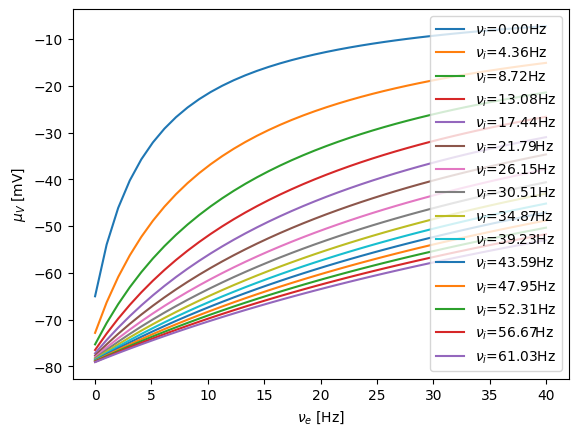

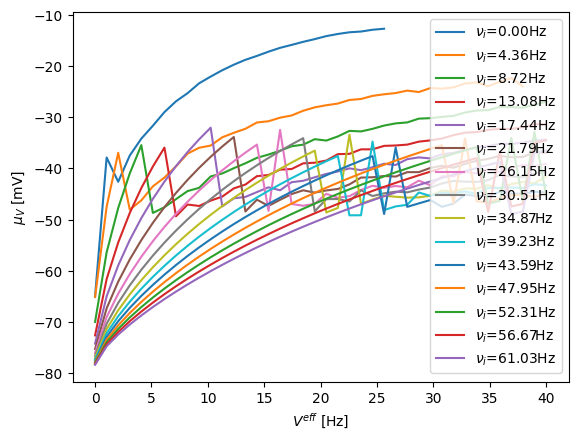

In [11]:
for i, nu_i in enumerate(nu_i_range[:15]):
    plt.plot(nu_e_range, mu_V[:,i], label=fr'$\nu_i$={nu_i:.2f}Hz')
plt.legend()
plt.xlabel(r'$\nu_e$ [Hz]')
plt.ylabel(r'$\mu_V$ [mV]')
plt.show()

for i, nu_i in enumerate(nu_i_range[:15]):
    plt.plot(nu_e_range, v_eff[:,i], label=fr'$\nu_i$={nu_i:.2f}Hz')
plt.legend()
plt.xlabel(r'$V^{{eff}}$ [Hz]')
plt.ylabel(r'$\mu_V$ [mV]')
plt.show()

In [12]:
coefs = [v_eff.mean(), 1e-3,1e-3,1e-3]
coefs_fit = simulations.v_eff_curve_fit(coefs, v_eff, mu_V, sigma_V, tau_VN)

print(coefs_fit)

TypeError: v_eff_curve_fit() missing 2 required positional arguments: 'expansion_point' and 'expansion_norm'

# Fitting Zerlaut/diVolo model

- Zerlaut2016_HeterogeneousFiring - linear fit (fit for various neuron models)
$$ V_\text{thr}^\text{eff}(\mu_V,\sigma_V,\tau_V^N)=P_0+\sum_{x\in\{\mu_V,\sigma_V,\tau_V^N\}}P_x\cdot\left(\frac{x-x^0}{\delta x^0}\right)$$

- Zerlaut2018_ModelingMesoscopic - quadratic fit + logarithmic term
$$ V_\text{thr}^\text{eff}(\mu_V,\sigma_V,\tau_V^N)=P_0+\sum_{x\in\{\mu_V,\sigma_V,\tau_V^N\}}P_x\cdot\left(\frac{x-x^0}{\delta x^0}\right)+\sum_{x,y\in\{\mu_V,\sigma_V,\tau_V^N\}^2}P_{xy}\cdot\left(\frac{x-x^0}{\delta x^0}\right)\left(\frac{y-y^0}{\delta y^0}\right) +  P_{\mu_G}\log\frac{\mu_G}{g_L}$$

- diVolo2019_BiologicallyRealistic - quadratic fit
$$ V_\text{thr}^\text{eff}(\mu_V,\sigma_V,\tau_V^N)=P_0+\sum_{x\in\{\mu_V,\sigma_V,\tau_V^N\}}P_x\cdot\left(\frac{x-x^0}{\delta x^0}\right)+\sum_{x,y\in\{\mu_V,\sigma_V,\tau_V^N\}^2}P_{xy}\cdot\left(\frac{x-x^0}{\delta x^0}\right)\left(\frac{y-y^0}{\delta y^0}\right) $$


Ensure the simulatios time is much longer then $\tau_w$!


In [126]:
# coefs order:
# x0, x1, x2, x3, x1*x1, x1*x2, x1*x3, x2*x2, x2*x3, x3*x3

divolo_fit = {
    'divolo_exc' : np.array([-49.8, 5.06, -25., -0.41, 7.4, 1.2, 10.5, -40.7, -36.]),
    'divolo_inh' : np.array([-51.4, 4.0, -8.3, 0.2, -0.5, 4.5, 2.8, 1.4, -15.3, -14.6]),
    'expansion_point' : np.array([-60., 4e-3, 0.5]),
    'expansion_norm' : np.array([10e-3, 6e-3, 1.]),
}

In [130]:
reload(cell_library)
reload(simulations)

neurons = cell_library.load_divolo_model_parameters()
nu_e_range = np.linspace(0, 40, 10)
nu_i_range = np.linspace(0, 40, 10)


expansion_point = np.array([-60, 4e-3, 0.5])  # mV, mV, 1
expansion_norm = np.array([10e-3, 6e-3, 1.])  # mV, mV, 1

simulate = True


################################################################################

activities = dict()
adaptations = dict()

if simulate:
    for neuron_name, sim_pars in neurons.items():
        print(neuron_name)
        tau_w = sim_pars['neuron_params']['tau_w']
        sim_time = sim_pars['simulation_time']
        if sim_time < tau_w*10:
            sim_pars['simulation_time'] = tau_w*10 
        activity = np.zeros((nu_e_range.size, nu_i_range.size))
        adaptation = np.zeros((nu_e_range.size, nu_i_range.size))
        for i, nu_e in enumerate(nu_e_range):
            for j, nu_i in enumerate(nu_i_range):
                membrane_potential, spike_times, w = simulations.simulate_neuron_pynn(nu_e, nu_i, **sim_pars)
                activity[i, j] = simulations.activity_from_spikes(spike_times, sim_pars['simulation_time'])
                adaptation[i, j] = np.mean(w[w.size//2:])
        np.save(data_path / f'{neuron_name}-activity.npy', activity)
        np.save(data_path / f'{neuron_name}-adaptation.npy', adaptation)
        activities[neuron_name] = activity
        adaptations[neuron_name] = adaptation
else:
    for neuron_name in neurons:
        activities[neuron_name] = np.load(data_path / f'{neuron_name}-activity.npy')
        adaptations[neuron_name] = np.load(data_path / f'{neuron_name}-adaptation.npy')


################################################################################

mu_Vs = dict()
sigma_Vs = dict()
tau_Vs = dict()
tau_VNs = dict()
v_effs = dict()
coefs = dict()

for neuron_name, sim_pars in neurons.items():
    mu_V, sigma_V, tau_V, tau_VN = simulations.mean_potential_fluctuations(nu_e_range, nu_i_range, adaptations[neuron_name], sim_pars)
    v_eff = simulations.v_eff_from_data(activities[neuron_name], mu_V, sigma_V, tau_V, tau_VN)
    mu_Vs[neuron_name] = mu_V
    sigma_Vs[neuron_name] = sigma_V
    tau_Vs[neuron_name] = tau_V
    tau_VNs[neuron_name] = tau_VN
    v_effs[neuron_name] = v_eff

coefs_fit = dict()
coefs_minimize = dict()
for neuron_name in neurons:
    nnu_e, nnu_i = np.meshgrid(nu_e_range, nu_i_range, indexing='ij')
    act = activities[neuron_name]
    adapt = adaptations[neuron_name]
    v_eff = v_effs[neuron_name]
    mu_V = mu_Vs[neuron_name]
    sigma_V = sigma_Vs[neuron_name]
    tau_V = tau_Vs[neuron_name]
    tau_VN = tau_VNs[neuron_name]


    coefs_init = [1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3]
    coefs = simulations.v_eff_curve_fit(coefs_init, v_eff, mu_V, sigma_V, tau_VN, expansion_point, expansion_norm)
    coefs_fit[neuron_name] = coefs

    # coefs_init = [1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3]
    # coefs = simulations.v_eff_minimize_fit(coefs_init, v_eff, mu_V, sigma_V, tau_VN, expansion_point, expansion_norm)
    # coefs_minimize[neuron_name] = coefs


divolo_exc
divolo_inh


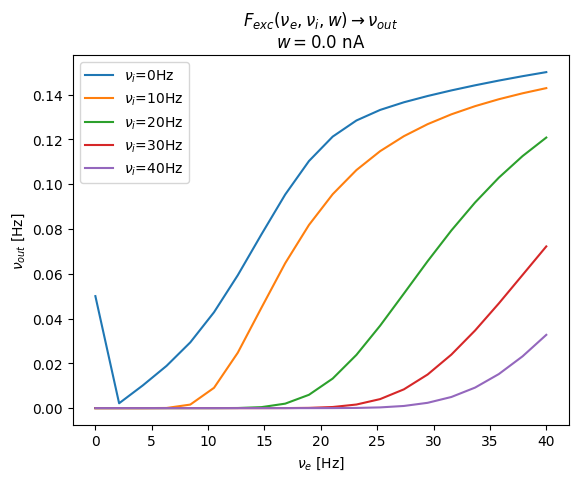

In [146]:
reload(simulations)
tf = simulations.get_transfer_function(coefs_fit['divolo_exc'], expansion_point, expansion_norm, neurons['divolo_exc'])

nu_e_range = np.linspace(0, 40, 20)
nu_i_range = np.linspace(0, 40, 5)
w = np.array([0.])

nu_out = tf(nu_e_range, nu_i_range, w)

for i, nu_i in enumerate(nu_i_range):
    plt.plot(nu_e_range, nu_out[:,i,0], label=fr'$\nu_i$={nu_i:.0f}Hz')
plt.legend()
plt.xlabel(r'$\nu_e$ [Hz]')
plt.ylabel(r'$\nu_{{out}}$ [Hz]')
plt.title(r'$F_{exc}(\nu_e,\nu_i,w)\to \nu_{out}$'+'\n'+ rf'$w={w[0]}$ nA')
plt.show()


In [164]:
mu_V, sigma_V, tau_V, tau_VN = simulations.mean_potential_fluctuations(0.01, 0., 0., neurons['divolo_exc'])
v_eff = simulations.v_eff_function(coefs_fit['divolo_exc'], mu_V, sigma_V, tau_VN, expansion_point, expansion_norm)
print(v_eff, mu_V, sigma_V, tau_V, tau_VN)

1/(2*tau_V) * erfc((v_eff-mu_V)/(np.sqrt(2)*sigma_V))

[[[-62.68717952]]] [[[-64.87025948]]] [[[0.32394646]]] [[[19.97005988]]] [[[1.33133733]]]


array([[[3.99258351e-13]]])

In [ ]:
# TODO: add the interactive plot
# 1. precomputed/data interactive exploration

# 2. interactive simulation
# running a simulation for each parameter update

# Interactive heatmap plot
widgets.interact(
    lambda fixed_axis,fixed_value : interactive_heatmap(data=data, fixed_axis=fixed_axis, fixed_value=numpy.round(fixed_value,2)),
    fixed_axis = widgets.Dropdown(options=[('L5a --> L5b', 0), ('L5b --> L5a', 1)], value=0, description='Fixed aff_ratio'),
    fixed_value = widgets.FloatSlider(0.1, min=0.0, max=0.6, step=.05, description='aff_ratio value'),
)

0.25677623419512285


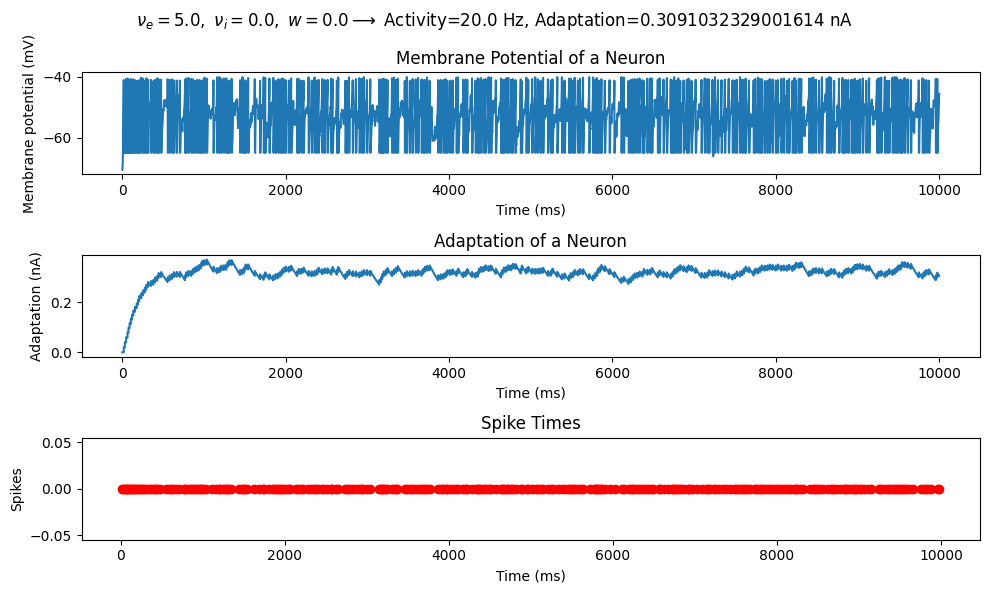

In [117]:
nu_e = 5.
nu_i = 0.
w = 0.

sim_pars = neurons['zerlaut_exc']
sim_pars['simulation_time'] = 10000.
membrane_potential, spike_times, w = simulations.simulate_neuron_pynn(nu_e, nu_i, **sim_pars)

# activity = simulations.activity_from_spikes(spike_times, sim_pars['simulation_time']) 
# activity = simulations.activity_from_spikes(spike_times, sim_pars['simulation_time']) 
activity = (spike_times> 9900).sum()/0.1
adaptation = np.mean(w[-100:])
mean_pot = float(np.mean(membrane_potential[-100:]))



tau_w = sim_pars['neuron_params']['tau_w']
b = sim_pars['neuron_params']['b']
a = sim_pars['neuron_params']['a']
e_L = sim_pars['neuron_params']['v_rest']

print(a*1e-3*(mean_pot-e_L)+b*tau_w*1e-3*activity)

plt.figure(figsize=(10, 6))
plt.suptitle(fr"$\nu_e={nu_e},~ \nu_i={nu_i},~ w={0.} \longrightarrow$ Activity={activity} Hz, Adaptation={adaptation}")
# Plot membrane potential
plt.subplot(3, 1, 1)
plt.plot(membrane_potential.times, membrane_potential)
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.title("Membrane Potential of a Neuron")

plt.subplot(3, 1, 2)
plt.plot(w.times, w)
plt.xlabel("Time (ms)")
plt.ylabel("Adaptation (nA)")
plt.title("Adaptation of a Neuron")

# Plot spike times
plt.subplot(3, 1, 3)
plt.plot(spike_times, [0]*len(spike_times), 'ro')  # Plot spike times as red dots
plt.xlabel("Time (ms)")
plt.ylabel("Spikes")
plt.title("Spike Times")
plt.tight_layout()
plt.show()

In [125]:
print(w[-50000:].mean())
print(w[-50000:].std())
print(membrane_potential[-50000:].mean())

activity = (spike_times> 5000).sum()/5
mean_pot = float(np.mean(membrane_potential[-50000:]))
print(a*1e-3*(mean_pot-e_L)+b*tau_w*activity*1e-3)

0.32130874310261615 nA
0.015285783136853323 nA
-54.61548442223794 mV
0.31953806231104825


In [113]:
float(mean_pot)

-50.80594145121929

In [116]:
print(a*1e-3*(mean_pot-e_L)+b*tau_w*activity)

0.25677623419512285


In [114]:
print(tau_w, b, a, e_L)
print(tau_w*b) 
print(-a*(e_L-mean_pot)*1e-3)

0.5 0.02 4.0 -65.0
0.01
0.05677623419512284


In [91]:
tau_w = neurons['zerlaut_exc']['neuron_params']['tau_w']*1e-3
b = neurons['zerlaut_exc']['neuron_params']['b']
a = neurons['zerlaut_exc']['neuron_params']['a']
e_L = neurons['zerlaut_exc']['neuron_params']['v_rest']

activities['zerlaut_exc']*tau_w*b +a*e_L*1e-3


array([[-0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26,
        -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26,
        -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26,
        -0.26, -0.26, -0.26],
       [-0.2 , -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26,
        -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26,
        -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26,
        -0.26, -0.26, -0.26],
       [-0.06, -0.22, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26,
        -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26,
        -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26,
        -0.26, -0.26, -0.26],
       [ 0.16, -0.06, -0.24, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26,
        -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26,
        -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26, -0.26,
        -0.26, -0.26, -0.26],
       [ 0.32,  0.  , -0.22,

In [86]:
adaptations['zerlaut_exc']

array([[-8.93494459e-05, -2.36266207e-02, -3.18856958e-02,
        -3.55870201e-02, -3.78147322e-02, -3.92738009e-02,
        -4.02806303e-02, -4.10197811e-02, -4.15874562e-02,
        -4.20323267e-02, -4.23847111e-02, -4.26769395e-02,
        -4.29315477e-02, -4.31474438e-02, -4.33337316e-02,
        -4.34962779e-02, -4.36409451e-02, -4.37714550e-02,
        -4.38859930e-02, -4.39902652e-02, -4.40854218e-02,
        -4.41710293e-02, -4.42496885e-02, -4.43213572e-02,
        -4.43881316e-02, -4.44498321e-02, -4.45058491e-02,
        -4.45582605e-02, -4.46074618e-02, -4.46536528e-02],
       [ 1.01538195e-01,  6.13161392e-03, -1.06761468e-02,
        -1.95321211e-02, -2.52055152e-02, -2.80072762e-02,
        -3.09360208e-02, -3.30079082e-02, -3.38152428e-02,
        -3.52459166e-02, -3.61030944e-02, -3.67122053e-02,
        -3.74616789e-02, -3.80506155e-02, -3.87408301e-02,
        -3.92307628e-02, -3.96404316e-02, -3.97168367e-02,
        -4.01221154e-02, -4.02340532e-02, -4.07387090e-

In [118]:
reload(simulations)
from scipy.optimize import curve_fit

# how to deal with nans:
# flatten the data, find the nans, remove them
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit


v_eff_function2 = lambda X, *args: simulations.v_eff_function(args, X[0], X[1], X[2], expansion_point = np.array([-60., 4e-3, 0.5]), expansion_norm = np.array([10e-3, 6e-3, 1.]))

for neuron_name, sim_pars in neurons.items():
    X = np.stack([mu_Vs[neuron_name], sigma_Vs[neuron_name], tau_VNs[neuron_name]], axis=0)
    y_data = v_effs[neuron_name]
    coefs_init = [v_eff.mean(), 1e-3,1e-3,1e-3]
    popt, pcov = curve_fit(v_eff_function2, X, y_data, p0 = coefs_init, nan_policy='omit')
    print(neuron_name, popt)


ValueError: non-broadcastable output operand with shape (20,) doesn't match the broadcast shape (20,20)

# Fitting cellular data